In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import Grid
import matplotlib.dates as mdates



In [2]:
def variable_osm(archivo,variable="Zone Mean Air Temperature",limpia_nombres=False):
    """ variable_osm(
    archivo: PathLike[str]',
    variable="Zone Mean Air Temperature",
    limpia_nombres=False,
    )
    Docstring:
    Lee un archivo separado por comas proveniente de OpenStudio. y regresa un dataframe
    y la lista de nombres de las columnas sin unidades si se ha especificado
    Parameters
    ----------
    archivo : str, path object or file-like object.
    variable : "Zone mean air temperature" por default.
    limpia_nombre : bool, default False.
        Si es True, limpia los nombres de las columnas. Puede limpiar las variables
        "Zone mean air temperature",
        "Zone Infiltration Air Change Rate".
    
    """
    nombres = np.genfromtxt(archivo,max_rows=1, dtype="U",delimiter=",")
    if limpia_nombres:
        if variable=="Zone Mean Air Temperature":
            zonas = [nombre[:-29] for nombre in nombres[1:]]
        if variable=="Zone Infiltration Air Change Rate":
            zonas = [nombre[:-29-10] for nombre in nombres[1:]]
    else:
        zonas = nombres[1:]
    tmp = pd.read_csv(archivo,skiprows=1,names=nombres,index_col=0,parse_dates=True)
    tmp.columns = zonas
    return tmp, zonas

In [3]:
def graph_mean_std_max(data,zonas,vmax=40,vmin=10,
                       renglones=5,columnas=5,figsize=(14,10),
                       unidades=None,xkcd=True):
    """ Grafica el día promedio para cada columna del dataframe recibido , la desviación
    estándard y los máximos y mínimos para el día promedio.
    """
    tmp = []
    for zona in zonas:
        tmp1 = data[zona].groupby(by=[data.index.time]).agg(["mean","std","max","min"])
        tmp1 = tmp1.add_prefix(zona+"_")
        tmp.append(tmp1)
    tmp2 = pd.concat(tmp,axis=1)
    tmp2.index = pd.to_datetime(tmp2.index,format="%H:%M:%S")
    def plot_mean_max_min(ax,data,zona,vmin=vmin,vmax=vmax):
        mean = zona + "_mean"
        std  = zona + "_std"
        Max = zona + "_max"
        Min  = zona + "_min"
        ax.plot(data[mean])
        ax.fill_between(data[mean].index,data[mean] + data[std],data[mean]-data[std],alpha=0.2)
        ax.plot(data[Max],"r:")
        ax.plot(data[Min],"r:")
        ax.set_ylim(vmin,vmax)
        ax.set_xlabel('Tiempo [hh]')
        ax.set_ylabel(unidades)
        ax.set_title(zona)
        ax.grid()
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6)) # tick every two hours
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    def grafica_grid(renglones, columnas):
        fig = plt.figure(figsize=figsize)
        grid = Grid(fig, rect=111, nrows_ncols=(renglones, columnas),axes_pad=0.25)
        for i,ax in enumerate(grid):
            try:
                mean = zonas[i] + "_mean"
                std  = zonas[i] + "_std"
                Max  = zonas[i] + "_max"
                Min  = zonas[i] + "_min"
                plot_mean_max_min(ax,tmp2,zonas[i],vmin=vmin,vmax=vmax)
            except:
                pass
        plt.tight_layout()
        
    if xkcd:
        with plt.xkcd():
            grafica_grid(renglones,columnas)
            
    else:
        grafica_grid(renglones,columnas)



In [4]:
archivo = "../osm/edificio/run/002_ExportVariabletoCSV/report_ZoneMeanAirTemperature_ZoneTimestep.csv"
temperaturas,zonas = variable_osm(archivo,limpia_nombres=True)


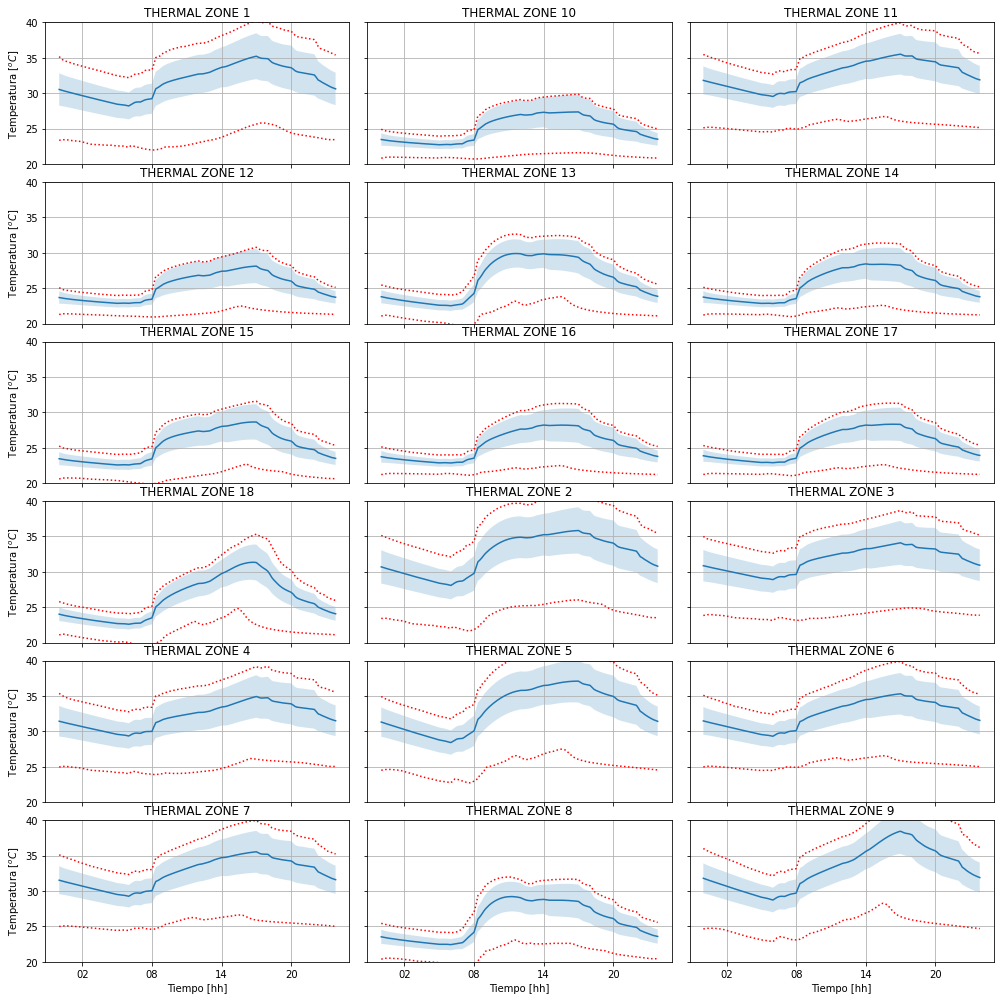

In [5]:
graph_mean_std_max(temperaturas,zonas,columnas=3,renglones=6,figsize=(14,14),vmin=20,
                   unidades="Temperatura [$^oC$]",xkcd=False)

In [6]:
archivo = "../osm/edificio/run/003_ExportVariabletoCSV/report_ZoneInfiltrationAirChangeRate_ZoneTimestep.csv"
infiltracion,zonas = variable_osm(archivo,variable="Zone Infiltration Air Change Rate",limpia_nombres=True)

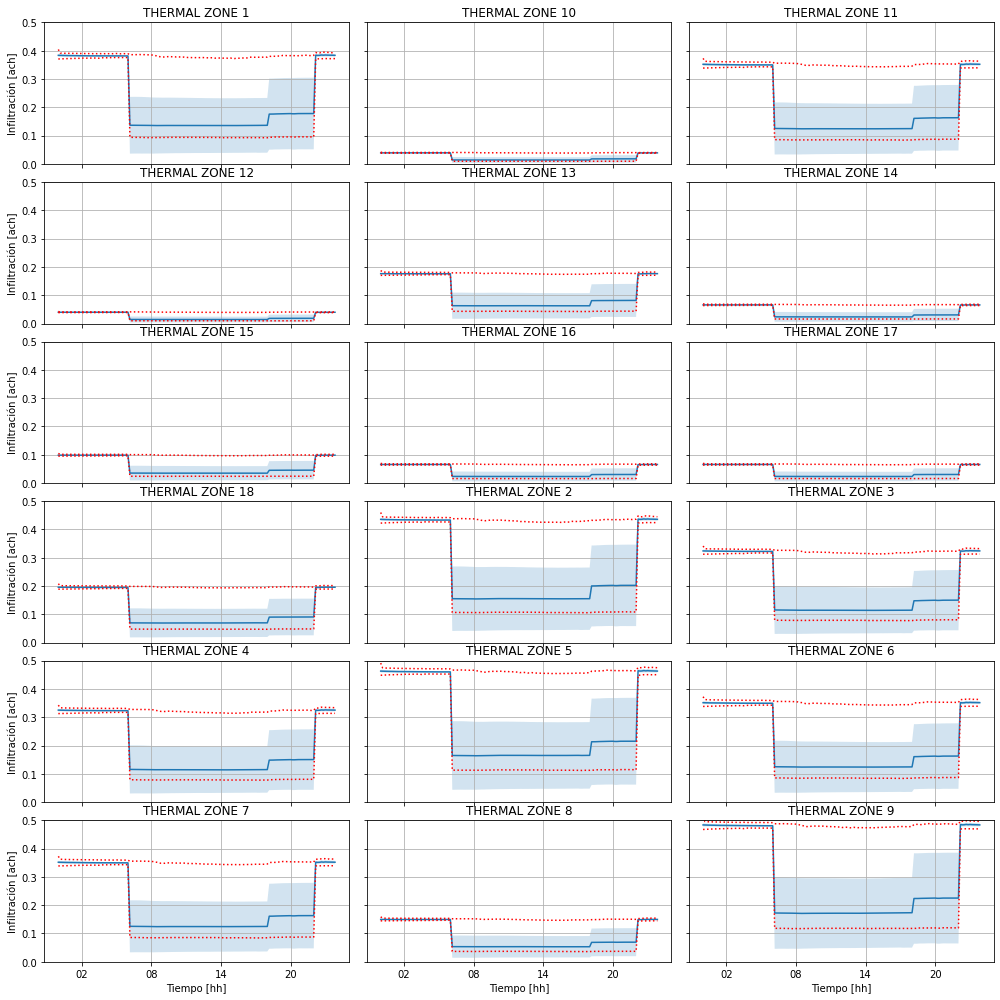

In [7]:
graph_mean_std_max(infiltracion,zonas,columnas=3,renglones=6,vmax=.5,vmin=0,
                   unidades="Infiltración [ach]",figsize=(14,14),xkcd=False)